In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
train = pd.read_csv('train.csv')
test =  pd.read_csv('test.csv')

Exploratory Data Analysis

In [7]:
train.head()

,date,store,item,sales
0,2013-01-01,1.0,1.0,13.0
1,2013-01-02,1.0,1.0,11.0
2,2013-01-03,1.0,1.0,14.0
3,2013-01-04,1.0,1.0,13.0
4,2013-01-05,1.0,1.0,10.0


In [8]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [9]:
train.describe()

,store,item,sales
count,829069.000000,829069.000000,829069.000000
mean,5.473531,23.204431,53.101984
std,2.875118,13.108311,29.144705
min,1.000000,1.000000,0.000000
25%,3.000000,12.000000,30.000000
50%,5.000000,23.000000,48.000000
75%,8.000000,35.000000,71.000000
max,10.000000,46.000000,231.000000


In [10]:
test.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


In [12]:
print('Max date from test set: %s' % train['date'].max())
import datetime
lag_size = len(test['date'].unique())
print('Forecast lag size: ', lag_size)

Max date from test set: 2017-12-31
Forecast lag size:  90


In [16]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()

            date    sales
0             20      0.0
1     2013-01-01  12659.0
2     2013-01-02  12595.0
3     2013-01-03  13392.0
4     2013-01-04  14495.0
...          ...      ...
1822  2017-12-27  18812.0
1823  2017-12-28  20196.0
1824  2017-12-29  21667.0
1825  2017-12-30  23081.0
1826  2017-12-31  24462.0

[1827 rows x 2 columns]


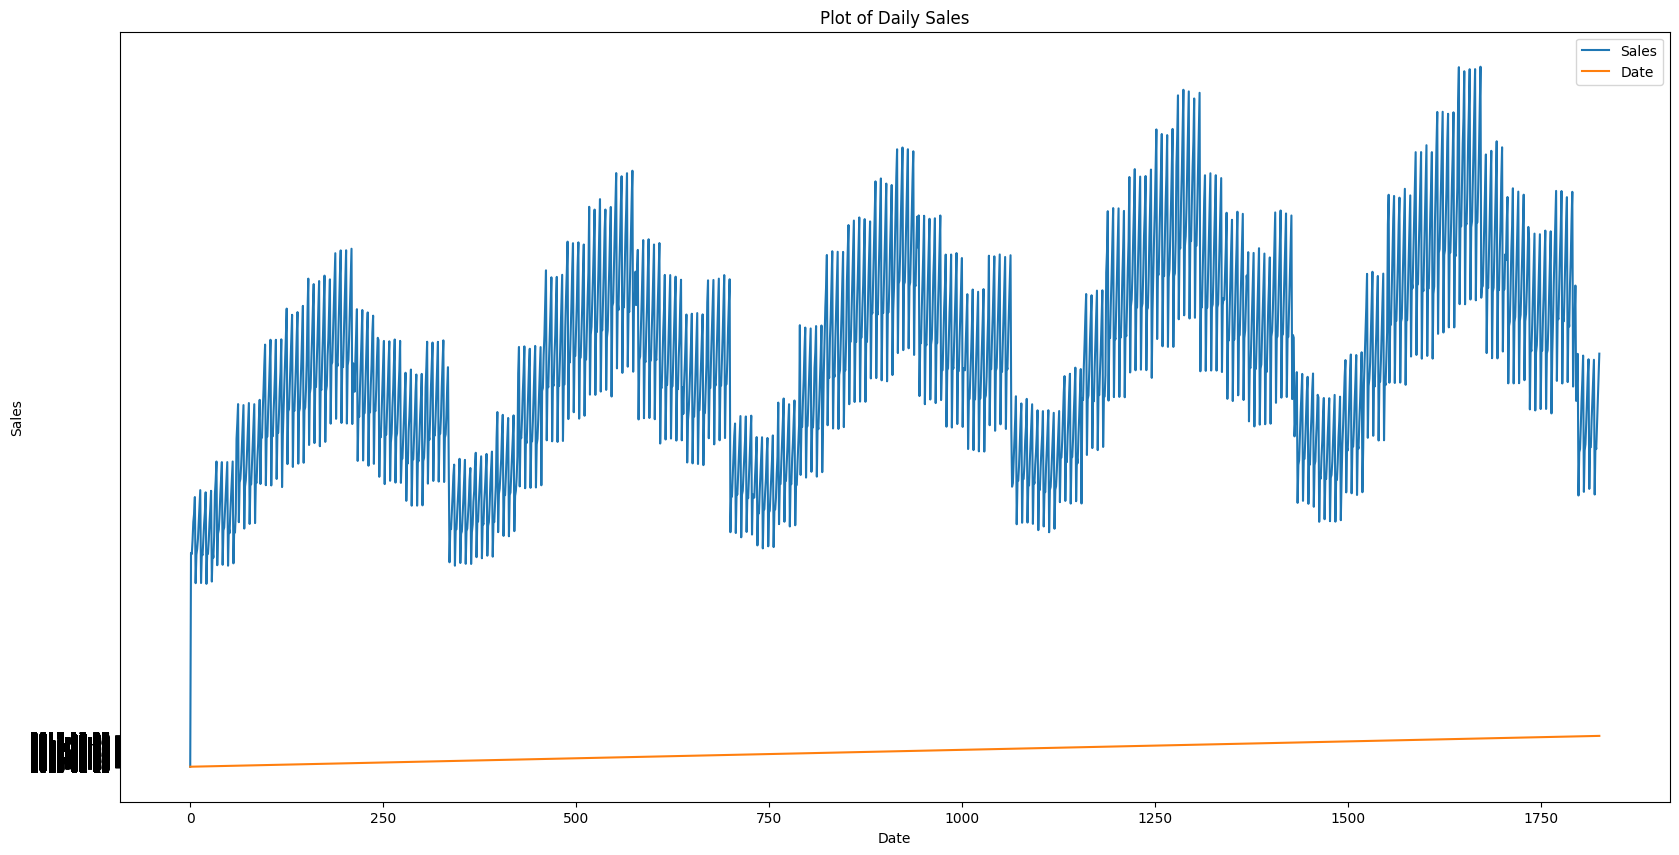

In [29]:
#Plotting Overall Sales across time
plt.figure(figsize=(20,10))
plt.plot(daily_sales['sales'], label='Sales')
plt.plot(daily_sales['date'], label='Date')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Plot of Daily Sales')
plt.legend()

# Show the plot
plt.show()

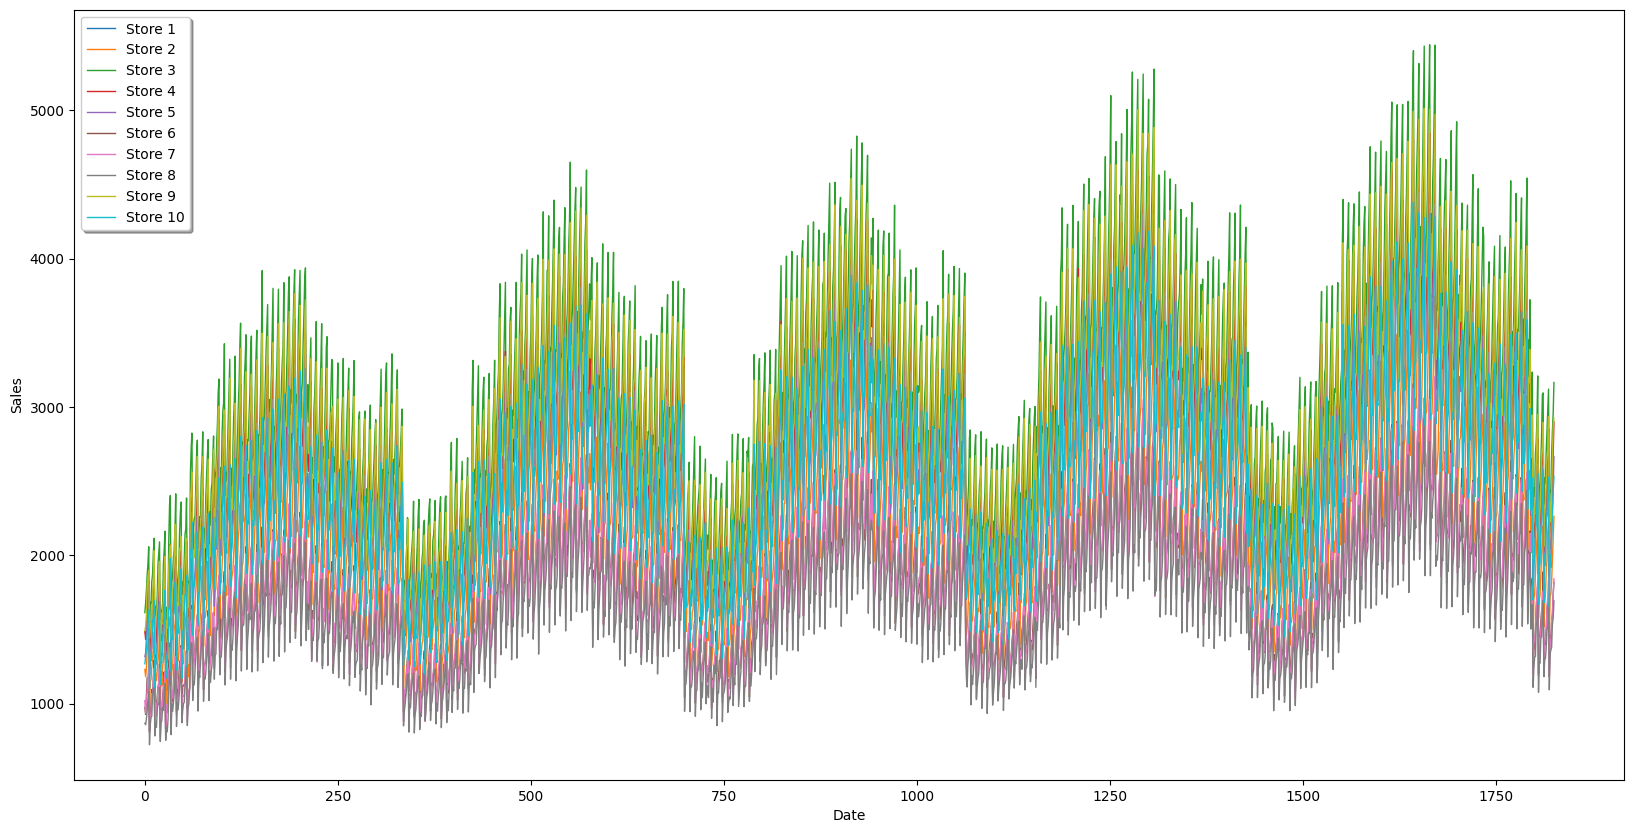

In [27]:
#Daily sales wrt stores
plt.figure(figsize=(20,10))
legend = []
for i in range(10):
    store_sales=train.loc[train['store'] == i]
    store_sales=store_sales.groupby('date', as_index=False)['sales'].sum()
    store_sales=store_sales.reset_index()['sales']
    plt.plot(store_sales, linewidth=1)
    legend.append(('Store '+str(i+1)))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(legend, loc='upper left', ncol=1, fancybox=True, shadow=True)
plt.show()

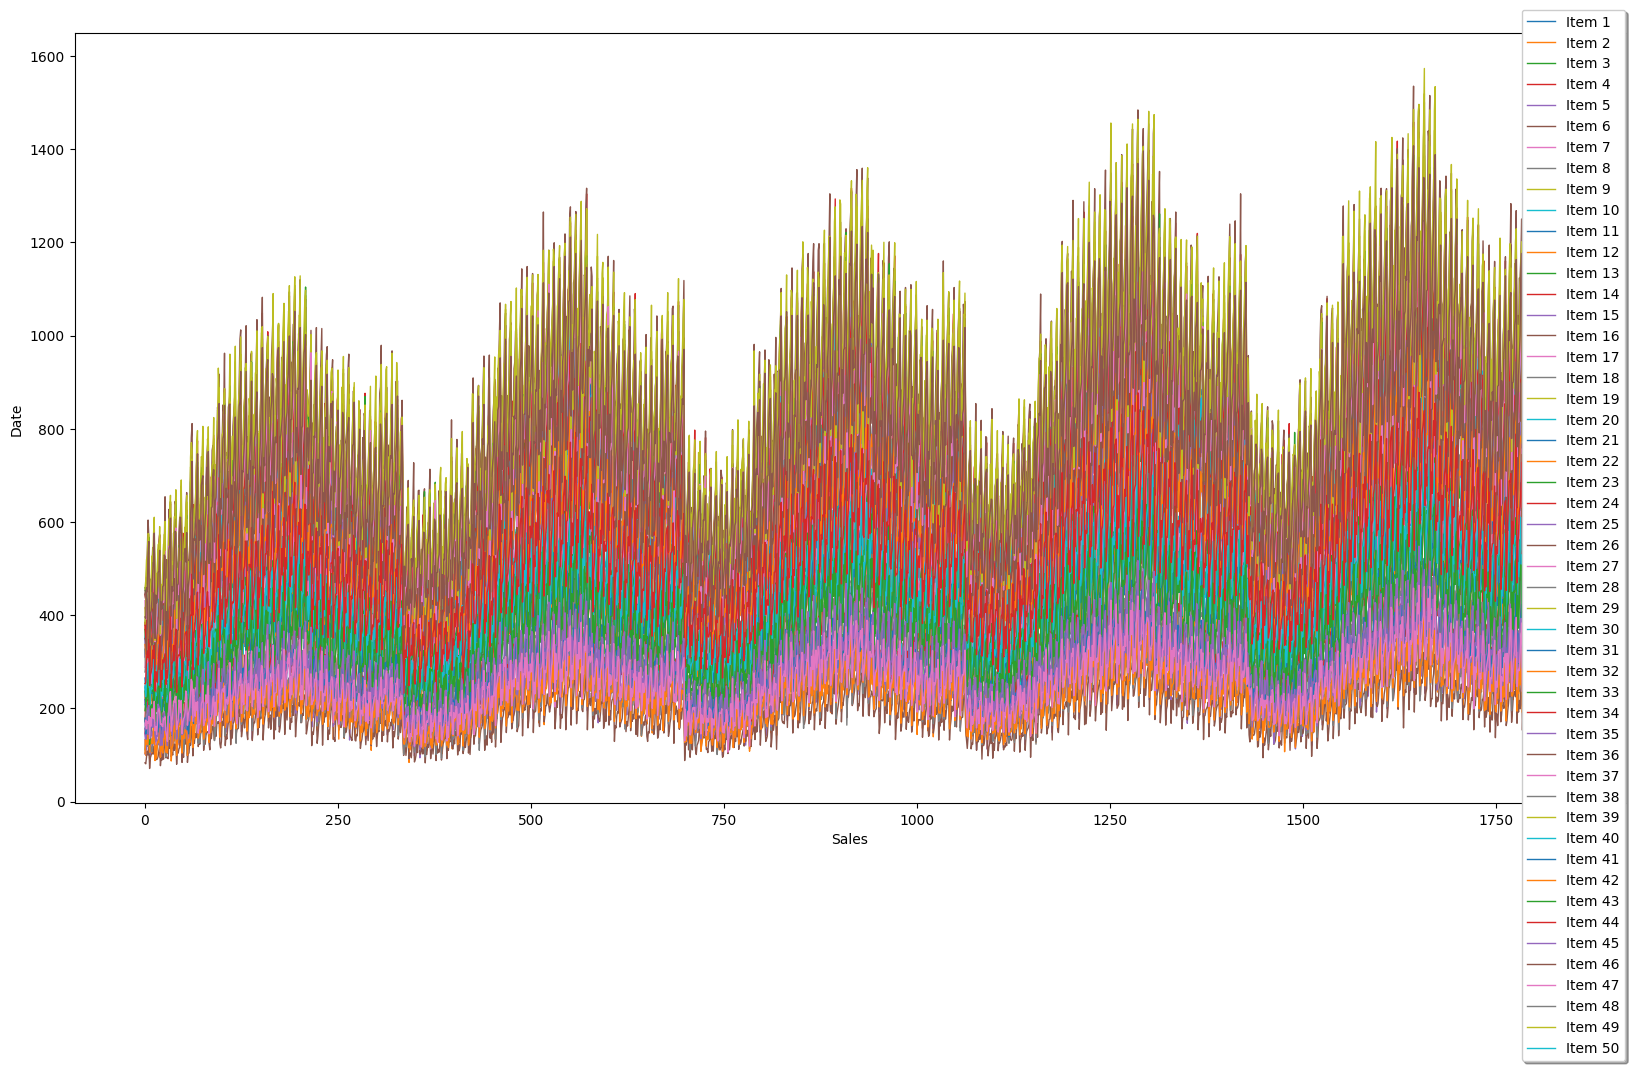

In [30]:
#Daily sales wrt items
plt.figure(figsize=(20,10))
legend = []
for i in range(50):
    item_sales=train.loc[train['item'] == i]
    item_sales=item_sales.groupby('date', as_index=False)['sales'].sum()
    item_sales=item_sales.reset_index()['sales']
    plt.plot(item_sales, linewidth=1)
    legend.append(('Item '+str(i+1)))
plt.xlabel('Sales')
plt.ylabel('Date')
plt.legend(legend, loc='upper right', ncol=1, bbox_to_anchor=[1.005, 1.04], fancybox=True, shadow=True)
plt.show()

Data Preprocessing

In [31]:
#Looking at average sales across items and stores
train = train[(train['date'] >= '2017-01-01')]
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1.0,1.0,2017-01-01,19.0
1,1.0,1.0,2017-01-02,15.0
2,1.0,1.0,2017-01-03,10.0
3,1.0,1.0,2017-01-04,16.0
4,1.0,1.0,2017-01-05,14.0


In [32]:
#Grouped training data
train_gp

,item,store,date,sales
0,1.0,1.0,2017-01-01,19.0
1,1.0,1.0,2017-01-02,15.0
2,1.0,1.0,2017-01-03,10.0
3,1.0,1.0,2017-01-04,16.0
4,1.0,1.0,2017-01-05,14.0
...,...,...,...,...
165705,46.0,4.0,2017-12-27,46.0
165706,46.0,4.0,2017-12-28,53.0
165707,46.0,4.0,2017-12-29,52.0
165708,46.0,4.0,2017-12-30,70.0


In [33]:
#Transforming the data into a time series problem - series_to_supervised converts a time series dataset into a
#supervised learning problem. The goal is to prepare the data for training a machine learning model, where past
#observations are used to predict future observations.

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
series

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1.0,1.0,24.0,1.0,1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165615,46.0,4.0,57.0,46.0,4.0,75.0,46.0,4.0,88.0,46.0,...,66.0,46.0,4.0,56.0,46.0,4.0,61.0,46.0,4.0,46.0
165616,46.0,4.0,75.0,46.0,4.0,88.0,46.0,4.0,79.0,46.0,...,56.0,46.0,4.0,61.0,46.0,4.0,84.0,46.0,4.0,53.0
165617,46.0,4.0,88.0,46.0,4.0,79.0,46.0,4.0,80.0,46.0,...,61.0,46.0,4.0,84.0,46.0,4.0,87.0,46.0,4.0,52.0
165618,46.0,4.0,79.0,46.0,4.0,80.0,46.0,4.0,50.0,46.0,...,84.0,46.0,4.0,87.0,46.0,4.0,77.0,46.0,4.0,70.0


In [34]:
#Using the current timestep and the last 29 days to forecast 90 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1.0,1.0,24.0,1.0,1.0,19.0


In [37]:
#Dropping rows with different item/store values other than the shifted columns
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [38]:
# Removing unnecessary columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [39]:
#Splitting the dataset into Training and Testing set
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=42)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (91472, 30)
Validation set shape (60982, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
142058,43.0,38.0,32.0,41.0,33.0,43.0,42.0,30.0,35.0,52.0,...,31.0,40.0,32.0,39.0,74.0,66.0,55.0,42.0,42.0,57.0
103243,74.0,89.0,111.0,100.0,74.0,74.0,101.0,80.0,124.0,101.0,...,83.0,100.0,101.0,104.0,107.0,82.0,81.0,83.0,79.0,104.0
94865,65.0,45.0,38.0,65.0,74.0,48.0,78.0,85.0,48.0,53.0,...,81.0,77.0,50.0,53.0,49.0,58.0,53.0,77.0,79.0,46.0
147535,11.0,16.0,15.0,18.0,10.0,8.0,17.0,15.0,12.0,18.0,...,17.0,17.0,27.0,9.0,14.0,15.0,15.0,14.0,13.0,19.0
14598,26.0,21.0,19.0,19.0,18.0,21.0,19.0,24.0,25.0,22.0,...,24.0,16.0,22.0,24.0,19.0,18.0,16.0,29.0,22.0,15.0


In [40]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (91472, 30, 1)
Validation set shape (60982, 30, 1)


Model Evaluation: In this step, we have chosen LSTM model which sees the input data as a sequence, so it's able to learn patterns from sequenced data, especially patterns from long sequences.

In [41]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
model_lstm.compile(optimizer='adam', loss='mse')
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=40, verbose=2)

Epoch 1/40
2859/2859 - 54s - loss: 639.2308 - val_loss: 440.7623 - 54s/epoch - 19ms/step
Epoch 2/40
2859/2859 - 50s - loss: 428.9294 - val_loss: 420.6335 - 50s/epoch - 17ms/step
Epoch 3/40
2859/2859 - 51s - loss: 414.0522 - val_loss: 404.3371 - 51s/epoch - 18ms/step
Epoch 4/40
2859/2859 - 50s - loss: 399.6958 - val_loss: 404.8145 - 50s/epoch - 17ms/step
Epoch 5/40
2859/2859 - 50s - loss: 393.2256 - val_loss: 383.7619 - 50s/epoch - 18ms/step
Epoch 6/40
2859/2859 - 49s - loss: 378.3143 - val_loss: 366.6667 - 49s/epoch - 17ms/step
Epoch 7/40
2859/2859 - 50s - loss: 1810.6157 - val_loss: 539.5785 - 50s/epoch - 18ms/step
Epoch 8/40
2859/2859 - 50s - loss: 8654.8867 - val_loss: 500.5057 - 50s/epoch - 17ms/step
Epoch 9/40
2859/2859 - 50s - loss: 493.6948 - val_loss: 486.3953 - 50s/epoch - 17ms/step
Epoch 10/40
2859/2859 - 51s - loss: 480.6520 - val_loss: 473.3308 - 51s/epoch - 18ms/step
Epoch 11/40
2859/2859 - 50s - loss: 472.3115 - val_loss: 460.9110 - 50s/epoch - 17ms/step
Epoch 12/40
2859/

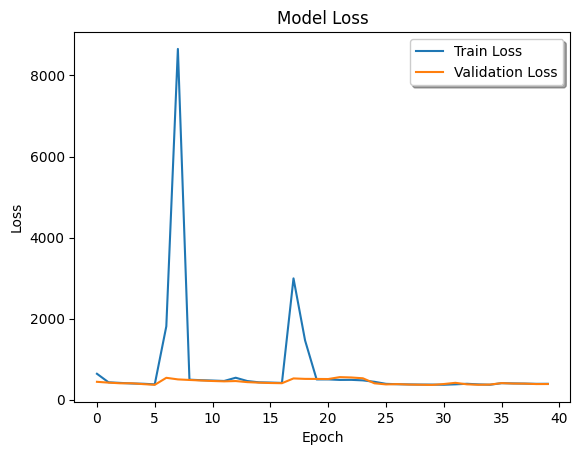

In [43]:
#Performance measure
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

In [44]:
# Predicting the prices on test data
predicted_sales = model_lstm.predict(X_valid_series)

#Flatten the 2 dimensional array so we can plot it with matplotlib
Y_valid = Y_valid.flatten()
predicted_sales = predicted_sales.flatten()

1906/1906 [==============================] - 11s 6ms/step


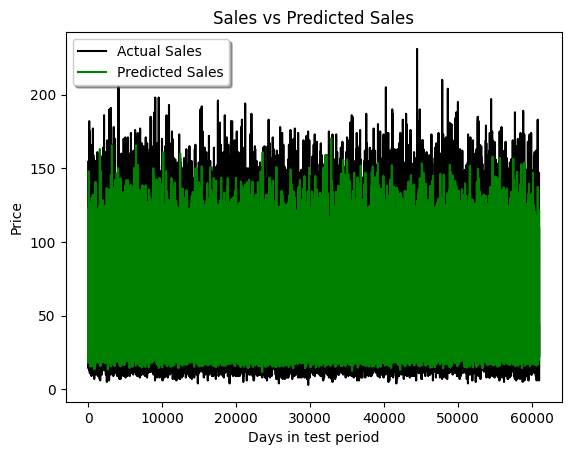

In [45]:
#Plot actuals vs predicted sales
plt.plot(Y_valid, color='black', label=f"Actual Sales")
plt.plot(predicted_sales, color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend(fancybox=True, shadow=True)
plt.show()

In [46]:
lstm_train_pred = model_lstm.predict(X_train_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, predicted_sales)))

2859/2859 [==============================] - 18s 6ms/step
Train rmse: 19.611218587168082
Validation rmse: 19.64882441207169


In [ ]:
# summarize history for loss (not required)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()